In [1]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path for imports (adjust if needed)
sys.path.append('../..')
from src.pyasterix.connection import Connection
from src.pyasterix.dataframe.base import AsterixDataFrame

# Configure notebook settings
%matplotlib inline
plt.style.use('ggplot')
sns.set_style("whitegrid")

# AsterixDB DataFrame API Tutorial

AsterixDB is a scalable, open-source Big Data Management System (BDMS) that stores, indexes, and manages large collections of semi-structured data. This tutorial demonstrates how to use our high-level DataFrame API to interact with AsterixDB using familiar Pythonic syntax.

## Features
- SQL++-like query capabilities with a pandas-like interface
- Seamless integration with pandas, matplotlib, and other Python data science tools
- Easy conversion to pandas DataFrame for advanced analytics

Let's explore how to use this API to query, analyze, and visualize data from AsterixDB!

In [2]:
# Connect to AsterixDB
connection = Connection(base_url="http://localhost:19002")
print("Connected to AsterixDB!")

# Define a sample dataverse and dataset creation function
def create_sample_dataset():
    """Create sample datasets for the tutorial"""
    cursor = connection.cursor()
    
    print("Creating sample dataverse and datasets...")
    
    # Drop dataverse if exists and create a new one
    cursor.execute("""
        DROP DATAVERSE TinySocial IF EXISTS;
        CREATE DATAVERSE TinySocial;
        USE TinySocial;
        
        CREATE TYPE UserType AS {
            id: int,
            name: string,
            age: int,
            location: point?,
            interests: {{ string }},
            joined_date: datetime,
            is_active: boolean
        };
        
        CREATE TYPE PostType AS {
            post_id: int,
            user_id: int,
            content: string,
            tags: [string],
            created_at: datetime,
            location: point?
        };
        
        CREATE DATASET Users(UserType)
            PRIMARY KEY id;
            
        CREATE DATASET Posts(PostType)
            PRIMARY KEY post_id;
    """)
    
    print("Inserting sample data...")
    
    # Insert sample data
    cursor.execute("""
        USE TinySocial;
        
        INSERT INTO Users([
            {"id": 1, "name": "Alice", "age": 28, "location": point("37.7749,-122.4194"), 
             "interests": {{"hiking", "photography", "coding"}}, 
             "joined_date": datetime("2020-01-15T10:30:00"), "is_active": true},
            {"id": 2, "name": "Bob", "age": 35, "location": point("40.7128,-74.0060"), 
             "interests": {{"gaming", "cooking", "music"}}, 
             "joined_date": datetime("2019-11-20T14:15:00"), "is_active": true},
            {"id": 3, "name": "Charlie", "age": 24, "location": point("34.0522,-118.2437"), 
             "interests": {{"movies", "photography", "travel"}}, 
             "joined_date": datetime("2021-03-10T09:45:00"), "is_active": false},
            {"id": 4, "name": "Diana", "age": 31, "location": point("41.8781,-87.6298"), 
             "interests": {{"reading", "yoga", "cooking"}}, 
             "joined_date": datetime("2020-07-22T16:20:00"), "is_active": true},
            {"id": 5, "name": "Evan", "age": 27, "location": point("29.7604,-95.3698"), 
             "interests": {{"running", "coding", "music"}}, 
             "joined_date": datetime("2021-01-05T11:10:00"), "is_active": true}
        ]);
        
        INSERT INTO Posts([
            {"post_id": 101, "user_id": 1, "content": "Beautiful hike today!", 
             "tags": ["nature", "outdoors", "hiking"], 
             "created_at": datetime("2022-01-10T15:30:00"), "location": point("37.7749,-122.4194")},
            {"post_id": 102, "user_id": 2, "content": "New recipe I tried today", 
             "tags": ["food", "cooking", "recipe"], 
             "created_at": datetime("2022-01-12T18:45:00"), "location": point("40.7128,-74.0060")},
            {"post_id": 103, "user_id": 1, "content": "Check out this photo I took!", 
             "tags": ["photography", "art", "nature"], 
             "created_at": datetime("2022-01-15T10:20:00"), "location": point("37.8199,-122.4783")},
            {"post_id": 104, "user_id": 4, "content": "Just finished this amazing book", 
             "tags": ["books", "reading", "review"], 
             "created_at": datetime("2022-01-18T21:15:00"), "location": point("41.8781,-87.6298")},
            {"post_id": 105, "user_id": 3, "content": "Movie night recommendations?", 
             "tags": ["movies", "question", "entertainment"], 
             "created_at": datetime("2022-01-20T19:30:00"), "location": point("34.0522,-118.2437")},
            {"post_id": 106, "user_id": 5, "content": "New coding project launched!", 
             "tags": ["coding", "technology", "project"], 
             "created_at": datetime("2022-01-22T14:10:00"), "location": point("29.7604,-95.3698")},
            {"post_id": 107, "user_id": 2, "content": "Jamming to some good music", 
             "tags": ["music", "relax", "weekend"], 
             "created_at": datetime("2022-01-23T16:40:00"), "location": point("40.7128,-74.0060")},
            {"post_id": 108, "user_id": 4, "content": "Morning yoga session was refreshing", 
             "tags": ["yoga", "wellness", "morning"], 
             "created_at": datetime("2022-01-25T08:15:00"), "location": point("41.8781,-87.6298")}
        ]);
    """)
    
    print("Sample data created successfully!")

# Create the sample dataset
create_sample_dataset()

INFO:src.pyasterix.connection:Initialized Connection with base URL: http://localhost:19002


Connected to AsterixDB!
Creating sample dataverse and datasets...
Inserting sample data...
Sample data created successfully!


In [ ]:
# Section 1: Basic DataFrame Operations

# Create DataFrame object for Users dataset
users_df = AsterixDataFrame(connection, "TinySocial.Users")

# Display all users
print("Fetching all users...")
results = users_df.execute() # SELECT * FROM TinySocial.Users;
print(f"Found {len(results)} users")

print(f"Asterix Dataframe: \n",results) #printing results as it is

# Convert to pandas DataFrame for display
pandas_df = pd.DataFrame(results)

print(f"Pandas Dataframe: \n",pandas_df)

# Selecting specific columns
print("\nSelecting specific columns (name, age):")
users_name_age = users_df[["name", "age"]].execute()
print(users_name_age) # multiple ways in which we can view our dataframe

# queries are built but not executed untill we do .execute() -> lazy execution 

# Getting a single user by ID
print("\nFetching user with ID = 2:")
user_2 = users_df[users_df["id"] == 2]
# user_2 = users_df.filter(users_df["id"] == 2).execute()

display(user_2) # using display to view 

Fetching all users...
Found 5 users
Asterix Dataframe: 
    id     name  age              location                      interests  \
0   1    Alice   28  [37.7749, -122.4194]  [hiking, photography, coding]   
1   2      Bob   35    [40.7128, -74.006]       [gaming, cooking, music]   
2   3  Charlie   24  [34.0522, -118.2437]  [movies, photography, travel]   
3   4    Diana   31   [41.8781, -87.6298]       [reading, yoga, cooking]   
4   5     Evan   27   [29.7604, -95.3698]       [running, coding, music]   

               joined_date  is_active  
0  2020-01-15T10:30:00.000       True  
1  2019-11-20T14:15:00.000       True  
2  2021-03-10T09:45:00.000      False  
3  2020-07-22T16:20:00.000       True  
4  2021-01-05T11:10:00.000       True  
Pandas Dataframe: 
    id     name  age              location                      interests  \
0   1    Alice   28  [37.7749, -122.4194]  [hiking, photography, coding]   
1   2      Bob   35    [40.7128, -74.006]       [gaming, cooking, music]  

      name  age
0    Alice   28
1      Bob   35
2  Charlie   24
3    Diana   31
4     Evan   27

In [4]:
# Section 2: Filtering Data with DataFrame API

# Filter by a simple condition
print("Users older than 30:")
users_df = AsterixDataFrame(connection, "TinySocial.Users")
older_users = users_df.filter(users_df["age"] > 30).execute()
display(older_users.to_pandas())

# Simple logical operators
print("\nUsers who are older than 25 AND active:")
users_df = AsterixDataFrame(connection, "TinySocial.Users")
active_older = users_df.filter(
    (users_df["age"] > 25) & 
    (users_df["is_active"] == True)
).execute()
display(active_older.to_pandas())

# Filtering by equality
print("\nUser named 'Alice':")
users_df = AsterixDataFrame(connection, "TinySocial.Users")
alice = users_df.filter(users_df["name"] == "Alice").execute()
display(alice.to_pandas())

# Order by
print("\nUsers ordered by age (descending):")
users_df = AsterixDataFrame(connection, "TinySocial.Users")
by_age = users_df.order_by("age", desc=True).execute()
display(by_age.to_pandas())

# Using limit to get top N
print("\nTop 3 users by age:")
users_df = AsterixDataFrame(connection, "TinySocial.Users")
top_three = users_df.order_by("age", desc=True).limit(3).execute()
display(top_three.to_pandas())


Users older than 30:


,id,name,age,location,interests,joined_date,is_active
0,2,Bob,35,"[40.7128, -74.006]","[gaming, cooking, music]",2019-11-20T14:15:00.000,True
1,4,Diana,31,"[41.8781, -87.6298]","[reading, yoga, cooking]",2020-07-22T16:20:00.000,True



Users who are older than 25 AND active:


,id,name,age,location,interests,joined_date,is_active
0,1,Alice,28,"[37.7749, -122.4194]","[hiking, photography, coding]",2020-01-15T10:30:00.000,True
1,2,Bob,35,"[40.7128, -74.006]","[gaming, cooking, music]",2019-11-20T14:15:00.000,True
2,4,Diana,31,"[41.8781, -87.6298]","[reading, yoga, cooking]",2020-07-22T16:20:00.000,True
3,5,Evan,27,"[29.7604, -95.3698]","[running, coding, music]",2021-01-05T11:10:00.000,True



User named 'Alice':


,id,name,age,location,interests,joined_date,is_active
0,1,Alice,28,"[37.7749, -122.4194]","[hiking, photography, coding]",2020-01-15T10:30:00.000,True



Users ordered by age (descending):


,id,name,age,location,interests,joined_date,is_active
0,2,Bob,35,"[40.7128, -74.006]","[gaming, cooking, music]",2019-11-20T14:15:00.000,True
1,4,Diana,31,"[41.8781, -87.6298]","[reading, yoga, cooking]",2020-07-22T16:20:00.000,True
2,1,Alice,28,"[37.7749, -122.4194]","[hiking, photography, coding]",2020-01-15T10:30:00.000,True
3,5,Evan,27,"[29.7604, -95.3698]","[running, coding, music]",2021-01-05T11:10:00.000,True
4,3,Charlie,24,"[34.0522, -118.2437]","[movies, photography, travel]",2021-03-10T09:45:00.000,False



Top 3 users by age:


,id,name,age,location,interests,joined_date,is_active
0,2,Bob,35,"[40.7128, -74.006]","[gaming, cooking, music]",2019-11-20T14:15:00.000,True
1,4,Diana,31,"[41.8781, -87.6298]","[reading, yoga, cooking]",2020-07-22T16:20:00.000,True
2,1,Alice,28,"[37.7749, -122.4194]","[hiking, photography, coding]",2020-01-15T10:30:00.000,True


In [14]:
# Section 3: Joins and Relationships

print("Joining Users and Posts:")
# Create DataFrames for both tables
users_df = AsterixDataFrame(connection, "TinySocial.Users")
posts_df = AsterixDataFrame(connection, "TinySocial.Posts")

# Join users with their posts
user_posts = users_df.join(
    posts_df,
    left_on="id",
    right_on="user_id",
    alias_left="u",
    alias_right="p"
).select([
    "u.name", 
    "u.age", 
    "p.content", 
    "p.created_at"
]).execute()

display(user_posts)

# Simple filtering on joined data
print("\nPosts by users older than 30:")
users_df = AsterixDataFrame(connection, "TinySocial.Users")
posts_df = AsterixDataFrame(connection, "TinySocial.Posts")

older_user_posts = users_df.join(
    posts_df,
    left_on="id",
    right_on="user_id",
    alias_left="u",
    alias_right="p"
).filter(
    users_df["age"] > 30
).select([
    "u.name", 
    "u.age", 
    "p.content"
]).execute()

display(older_user_posts)

Joining Users and Posts:


      name  age                              content               created_at
0    Alice   28                Beautiful hike today!  2022-01-10T15:30:00.000
1    Alice   28         Check out this photo I took!  2022-01-15T10:20:00.000
2      Bob   35           Jamming to some good music  2022-01-23T16:40:00.000
3      Bob   35             New recipe I tried today  2022-01-12T18:45:00.000
4  Charlie   24         Movie night recommendations?  2022-01-20T19:30:00.000
5    Diana   31      Just finished this amazing book  2022-01-18T21:15:00.000
6    Diana   31  Morning yoga session was refreshing  2022-01-25T08:15:00.000
7     Evan   27         New coding project launched!  2022-01-22T14:10:00.000


Posts by users older than 30:


    name  age                              content
0    Bob   35             New recipe I tried today
1    Bob   35           Jamming to some good music
2  Diana   31  Morning yoga session was refreshing
3  Diana   31      Just finished this amazing book

In [17]:
# Simple Aggregation Operations -- Supported by AsterixDat

# Count posts per user
print("Number of posts per user:")
posts_df = AsterixDataFrame(connection, "TinySocial.Posts")
post_counts = posts_df.select(["user_id"]).group_by(["user_id"]).count().execute()
display(post_counts)

# Sum of user ages 
print("\nTotal sum of user ages:")
users_df = AsterixDataFrame(connection, "TinySocial.Users")
total_age = users_df.sum(["age"]).execute()
display(total_age)

# Average age of users 
print("\nAverage user age:")
users_df = AsterixDataFrame(connection, "TinySocial.Users")
avg_age = users_df.avg(["age"]).execute()
display(avg_age)

# Total number of users
print("\nTotal number of users:")
users_df = AsterixDataFrame(connection, "TinySocial.Users")
user_count = users_df.count().execute()
display(user_count)

# Sum of all post IDs 
print("\nSum of all post IDs:")
posts_df = AsterixDataFrame(connection, "TinySocial.Posts")
post_id_sum = posts_df.sum(["post_id"]).execute()
display(post_id_sum)



Number of posts per user:


   user_id  count_star
0        1           2
1        2           2
2        3           1
3        4           2
4        5           1


Total sum of user ages:


   age_sum
0      145


Average user age:


   age_avg
0     29.0


Total number of users:


   count_star
0           5


Sum of all post IDs:


   post_id_sum
0          836

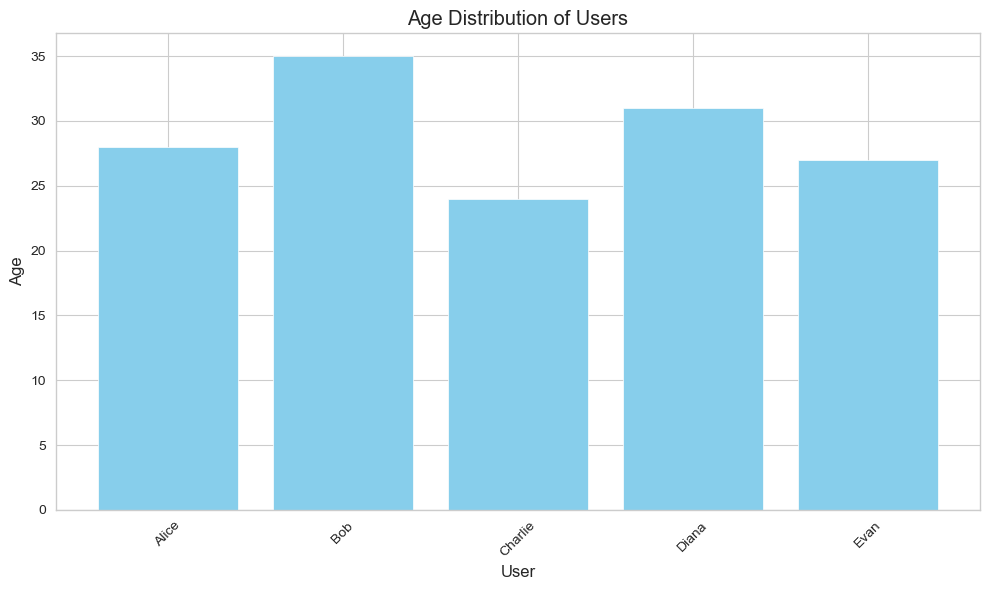

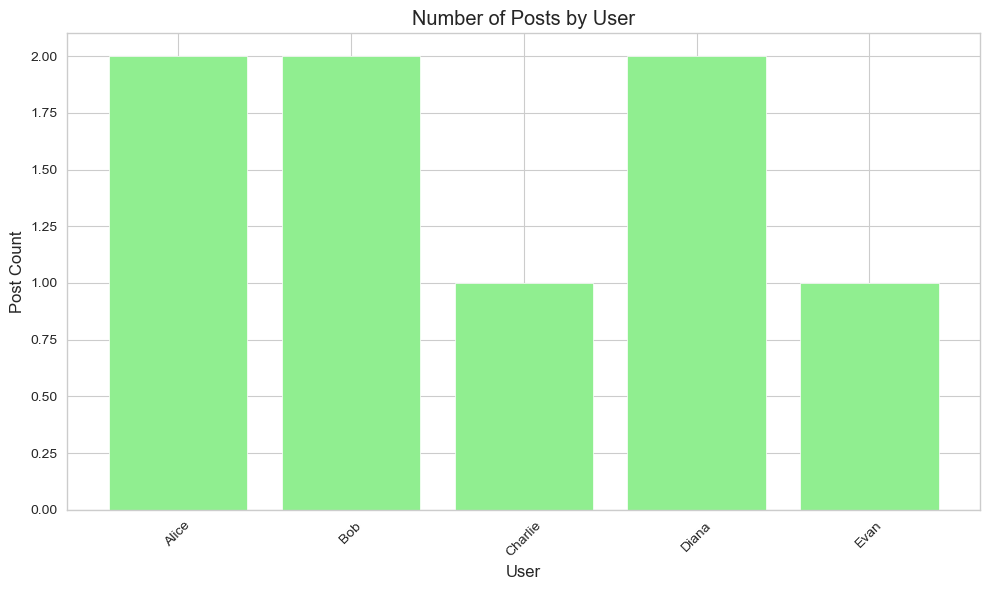

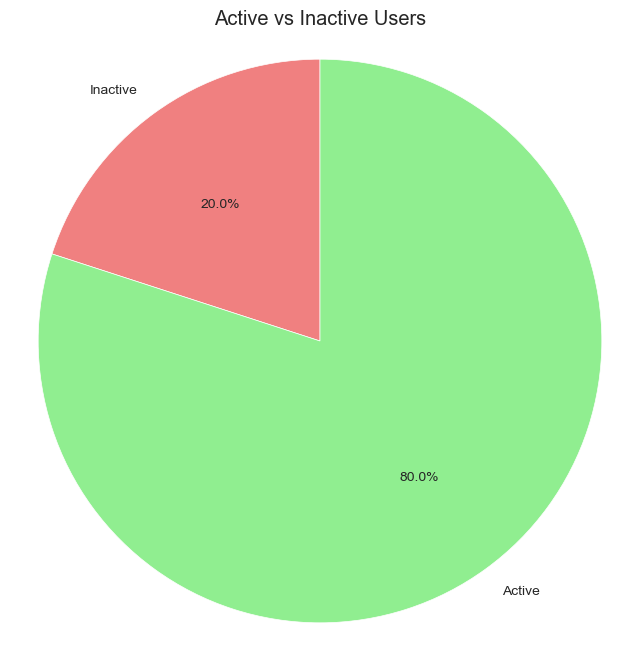

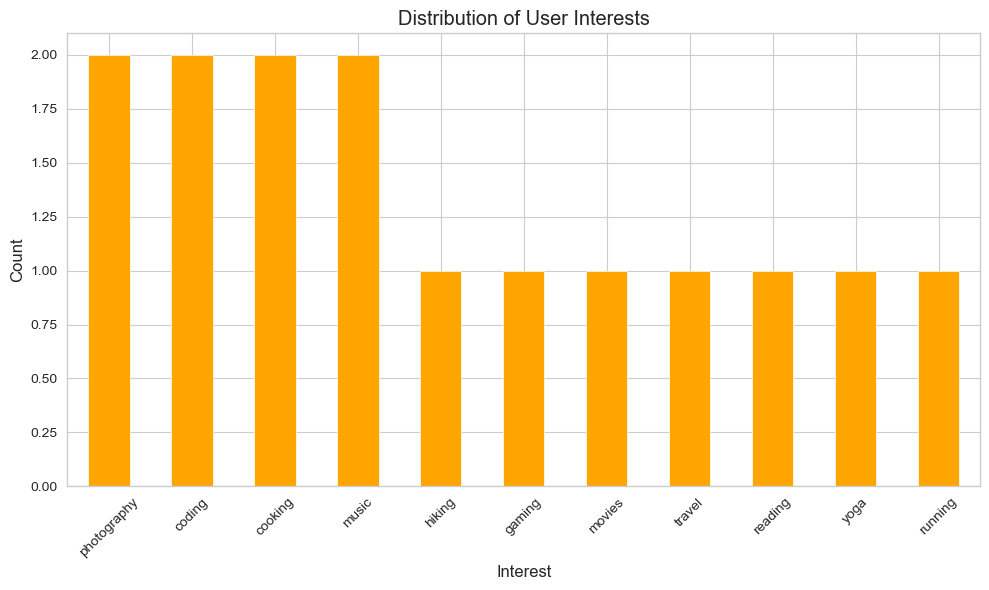

In [18]:
# Data Visualization with AsterixDB Results

# Fetch all users data
users_df = AsterixDataFrame(connection, "TinySocial.Users")
all_users = users_df.execute().to_pandas()

# Visualize user ages
plt.figure(figsize=(10, 6))
plt.bar(all_users['name'], all_users['age'], color='skyblue')
plt.title('Age Distribution of Users')
plt.xlabel('User')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Fetch all posts data
posts_df = AsterixDataFrame(connection, "TinySocial.Posts")
all_posts = posts_df.execute().to_pandas()

# Use pandas to prepare data for visualization
post_counts = all_posts.groupby('user_id').size().reset_index(name='count')

# Join with users to get names
user_post_counts = post_counts.merge(
    all_users[['id', 'name']], 
    left_on='user_id', 
    right_on='id'
)

# Visualize post counts
plt.figure(figsize=(10, 6))
plt.bar(user_post_counts['name'], user_post_counts['count'], color='lightgreen')
plt.title('Number of Posts by User')
plt.xlabel('User')
plt.ylabel('Post Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize active vs inactive users
active_counts = all_users.groupby('is_active').size()
plt.figure(figsize=(8, 8))
plt.pie(active_counts, labels=['Inactive', 'Active'], autopct='%1.1f%%', 
        colors=['lightcoral', 'lightgreen'], startangle=90)
plt.title('Active vs Inactive Users')
plt.axis('equal')
plt.show()

# Visualize interests distribution (count appearances of each interest)
interests_list = []
for user_interests in all_users['interests']:
    if isinstance(user_interests, list):
        interests_list.extend(user_interests)

interest_counts = pd.Series(interests_list).value_counts()

plt.figure(figsize=(10, 6))
interest_counts.plot(kind='bar', color='orange')
plt.title('Distribution of User Interests')
plt.xlabel('Interest')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Summary statistics with pandas:


,age
count,5.0000
mean,29.0000
std,4.1833
min,24.0000
25%,27.0000
50%,28.0000
75%,31.0000
max,35.0000



Users with 'coding' interest (filtered with pandas):


,id,name,age,location,interests,joined_date,is_active
0,1,Alice,28,"[37.7749, -122.4194]","[hiking, photography, coding]",2020-01-15T10:30:00.000,True
4,5,Evan,27,"[29.7604, -95.3698]","[running, coding, music]",2021-01-05T11:10:00.000,True



Post counts by user (using pandas):


,name,post_count
0,Alice,2
1,Bob,2
2,Charlie,1
3,Diana,2
4,Evan,1


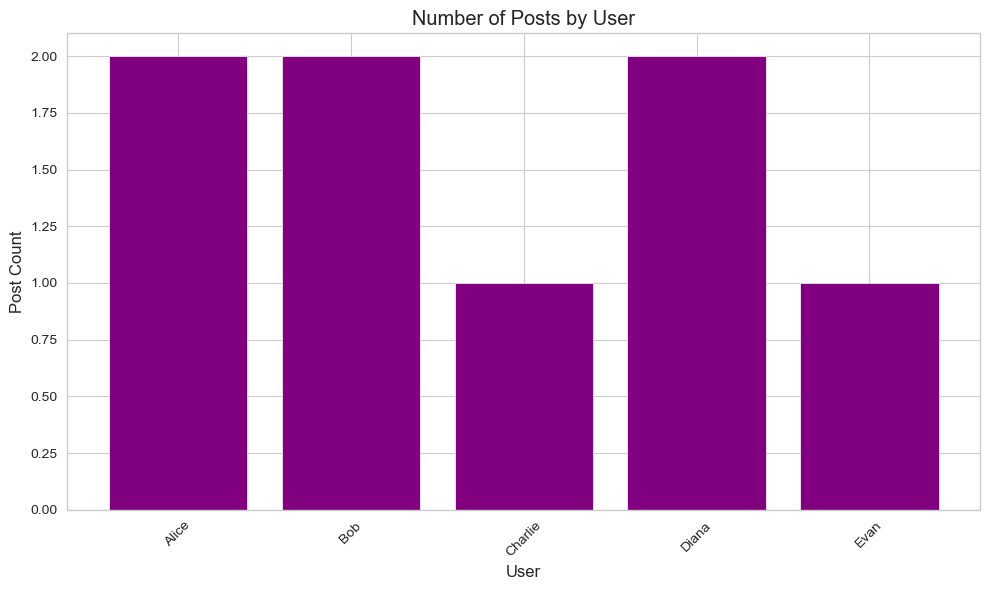


Percentage of total posts by user:


,name,post_count,percentage
0,Alice,2,25.0
1,Bob,2,25.0
2,Charlie,1,12.5
3,Diana,2,25.0
4,Evan,1,12.5



Cleaned up the sample dataverse.


In [19]:
# Integration with Python Data Science Stack

# Get all users and convert to pandas
users_df = AsterixDataFrame(connection, "TinySocial.Users")
users_df = users_df.execute()

pandas_df = users_df.to_pandas()

# Use pandas operations on the data
print("Summary statistics with pandas:")
display(pandas_df[['age']].describe())

# Advanced filtering with pandas
print("\nUsers with 'coding' interest (filtered with pandas):")
coding_users = pandas_df[pandas_df['interests'].apply(lambda x: 'coding' in x if isinstance(x, list) else False)]
display(coding_users)

# Get all posts
posts_df = AsterixDataFrame(connection, "TinySocial.Posts")
posts_by_user = posts_df.execute().to_pandas()

# Join with users data in pandas
user_post_data = pandas_df[['id', 'name']].merge(
    posts_by_user[['user_id', 'content']], 
    left_on='id', 
    right_on='user_id'
)

# Count posts by user using pandas
print("\nPost counts by user (using pandas):")
post_counts = user_post_data.groupby('name').size().reset_index(name='post_count')
display(post_counts)

# Create a simple visualization of post counts
plt.figure(figsize=(10, 6))
plt.bar(post_counts['name'], post_counts['post_count'], color='purple')
plt.title('Number of Posts by User')
plt.xlabel('User')
plt.ylabel('Post Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Demonstrate applying a pandas function to the data
print("\nPercentage of total posts by user:")
post_counts['percentage'] = post_counts['post_count'] / post_counts['post_count'].sum() * 100
display(post_counts)

# Clean up - drop the dataverse
cleanup_cursor = connection.cursor()
cleanup_cursor.execute("DROP DATAVERSE TinySocial IF EXISTS;")
print("\nCleaned up the sample dataverse.")